In [1]:
# Basic data manipulations
import pandas as pd
import numpy as np


# Handling images
from PIL import Image
import matplotlib.pyplot as plt

# Handling paths

import time

# Pytorch essentials
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
from torchvision.datasets import ImageFolder
! pip install torchsummary
import torchsummary



# Pytorch essentials for datasets.
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Pytorch way of data augmentation.
import torchvision
from torchvision import datasets, models, transforms, utils
from torchvision.transforms import v2

import cv2
import os
from glob import glob
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [2]:
root_path = '/kaggle/input/defungi'
df = pd.DataFrame({"path":[],"label":[], "class_id":[]})
label_dict = {
    "H1":0,
    "H2":1,
    "H3":2,
    "H5":3,
    "H6":4,
}
for key in label_dict:
    img_path = os.path.join(root_path, key)
    jpg_list = glob(img_path+'/*.jpg')
    for jpg in jpg_list:
        new_data =pd.DataFrame({"path":jpg,"label":key, "class_id":label_dict[key]}, index=[1])
        df = pd.concat([df, new_data], ignore_index=True)

df[["path"]] = df[["path"]].astype(str)
df[["label"]] = df[["label"]].astype(str)
df[["class_id"]] = df[["class_id"]].astype(int)

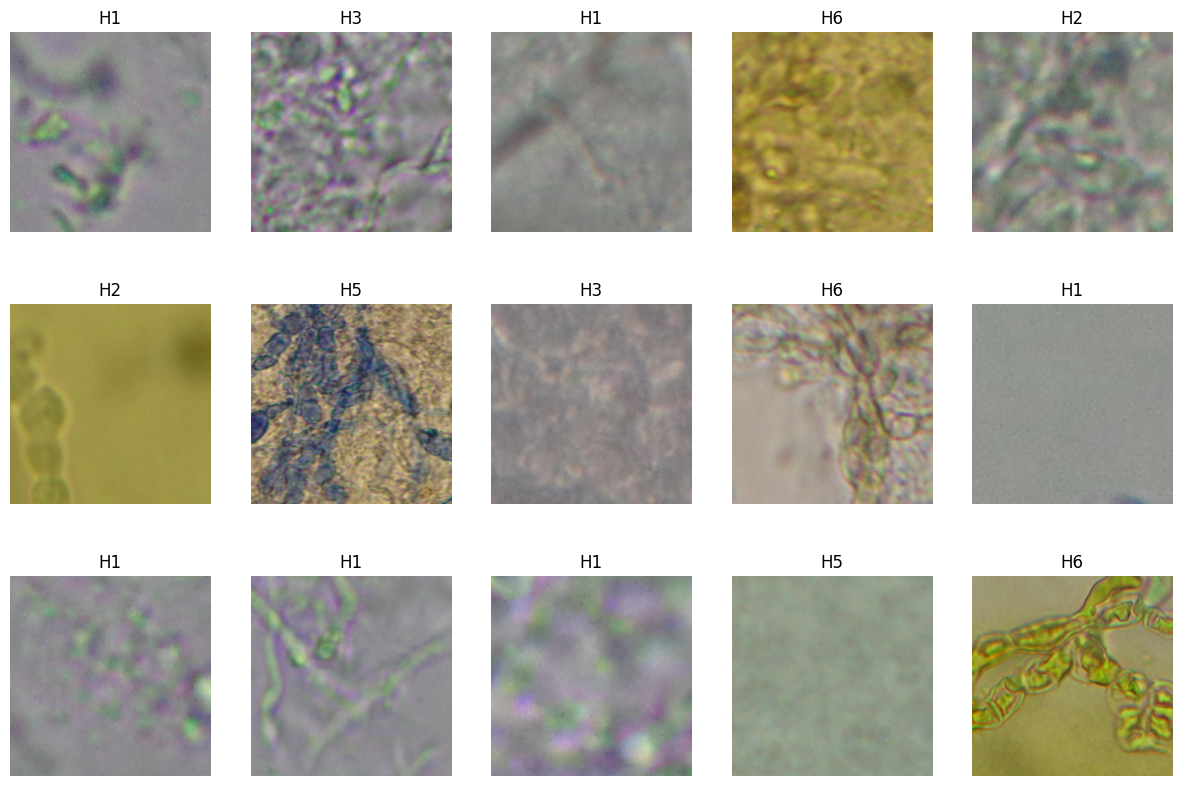

In [3]:
show_imgs = 15
idx = np.random.randint(0, len(df),size=show_imgs)
fig, axes = plt.subplots(show_imgs//5, 5, figsize=(15,10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    full_path = df.loc[idx[i]]['path']
    ax.imshow(plt.imread(full_path))
    ax.set_title(df.loc[idx[i]]['label'])
    ax.set_axis_off()

In [4]:
train_transforms = v2.Compose([
    v2.Resize(256),
    v2.RandomResizedCrop(size=(180, 180), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    # v2.RandomRotation(degrees=(-20, 20)),
    v2.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1), scale=(0.9, 1.1)),
    v2.RandomErasing(p=0.5, scale=(0.1,0.15)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])

test_transforms = v2.Compose([
    v2.Resize((224,224)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [5]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transforms_):
        self.df = dataframe
        # We'll use transforms for data augmentation and converting PIL images to torch tensors.
        self.transforms_ = transforms_
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image_path = self.df.iloc[index]['path']
        # img = Image.open(image_path).convert("LA")
        img = Image.open(image_path).convert("RGB")
        # img = Image.open(image_path)
        transformed_img = self.transforms_(img)
        class_id = self.df.iloc[index]['class_id']
        return transformed_img, class_id

In [6]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
num_workers = 2 if device=='cuda' else 4 # fixed by kaggle notebook
train_df, val_df = train_test_split(df,test_size=0.2,random_state=9898)
train_dataset = MyDataset(train_df, train_transforms)
val_dataset = MyDataset(val_df, test_transforms)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [7]:
print(f'train data:{len(train_df)}')
print(f'val data:{len(val_df)}')

train data:7291
val data:1823


In [8]:
class_size = 5
# model = models.efficientnet_v2_m(weights=models.EfficientNet_V2_M_Weights.DEFAULT)
model = models.efficientnet_v2_s(weights='DEFAULT')
# model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
model.classifier[1] = torch.nn.Linear(1280, class_size)
model(torch.randn((16,3,256,256))).shape

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 94.3MB/s]


torch.Size([16, 5])

In [9]:
def train(dataloader, model, loss_fn, optimizer, lr_scheduler):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch
    model.train()
    epoch_loss = 0.0
    epoch_correct = 0 
    for (data_,target_) in dataloader:
        target_ = target_.type(torch.LongTensor)
        data_, target_ = data_.to(device), target_.to(device)
        
        # First we'll clean the cache of optimizer
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(data_)
        
        # Computing loss 
        loss = criterion(outputs,target_)
        
        # Backward propagation
        loss.backward()
        
        # Optimizing model
        optimizer.step()
        
        # Computing statistics.
        epoch_loss = epoch_loss + loss.item()
        _,pred = torch.max(outputs,dim=1)
        epoch_correct = epoch_correct + torch.sum(pred == target_).item()
    lr_scheduler.step()
    return epoch_correct/size, epoch_loss/num_batches


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch
    epoch_loss = 0.0
    epoch_correct = 0 
    with torch.no_grad():
        # This will disable backward propagation
        model.eval()
        for (data_,target_) in dataloader:
            target_ = target_.type(torch.LongTensor)
            data_, target_ = data_.to(device), target_.to(device)

            # Forward propagation
            outputs = model(data_)
            
            # Computing loss 
            loss = criterion(outputs,target_)
            # Computing statistics.
            epoch_loss = epoch_loss + loss.item()
            _,pred = torch.max(outputs,dim=1)
            epoch_correct = epoch_correct + torch.sum(pred == target_).item()
    return  epoch_correct/size, epoch_loss/num_batches

In [10]:
model.to(device)
EPOCHS = 50

logs = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
}

criterion  = nn.CrossEntropyLoss()


# Optimizer which will use gradients to train model.
learning_rate = 0.0001
momentum = 0.9
weight_decay = 0.1
# optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=weight_decay, amsgrad=False)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)
lr_milestones = [7, 14, 21, 28, 35]
multi_step_lr_scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=lr_milestones, gamma=0.1)

# Earlystopping
patience = 5
counter = 0
best_loss = np.inf

for epoch in tqdm(range(EPOCHS)):
    train_acc, train_loss,  = train(train_loader, model, criterion, optimizer, multi_step_lr_scheduler)
    val_acc, val_loss = test(val_loader, model, criterion)
    print(f'EPOCH: {epoch} \
    train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
    val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} \
    Learning Rate: {optimizer.param_groups[0]["lr"]}')
    
    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)
    torch.save(model.state_dict(), "last.pth")
    # chcek improvement
    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "best.pth")
    else:
        counter += 1
    if counter >= patience:
        print("Earlystop!")
        break

  0%|          | 0/50 [00:00<?, ?it/s]

EPOCH: 0     train_loss: 0.9468, train_acc: 0.619     val_loss: 0.6468, val_acc: 0.726     Learning Rate: 0.0001


  2%|▏         | 1/50 [02:51<2:19:46, 171.15s/it]

EPOCH: 1     train_loss: 0.7064, train_acc: 0.707     val_loss: 0.5183, val_acc: 0.800     Learning Rate: 0.0001


  4%|▍         | 2/50 [04:55<1:55:04, 143.85s/it]

EPOCH: 2     train_loss: 0.6305, train_acc: 0.746     val_loss: 0.5112, val_acc: 0.796     Learning Rate: 0.0001


  6%|▌         | 3/50 [06:58<1:45:08, 134.23s/it]

EPOCH: 3     train_loss: 0.5914, train_acc: 0.762     val_loss: 0.4454, val_acc: 0.832     Learning Rate: 0.0001


  8%|▊         | 4/50 [09:01<1:39:21, 129.60s/it]

EPOCH: 4     train_loss: 0.5317, train_acc: 0.791     val_loss: 0.4274, val_acc: 0.834     Learning Rate: 0.0001


 10%|█         | 5/50 [11:04<1:35:30, 127.34s/it]

EPOCH: 5     train_loss: 0.4933, train_acc: 0.802     val_loss: 0.3769, val_acc: 0.850     Learning Rate: 0.0001


 12%|█▏        | 6/50 [13:08<1:32:29, 126.12s/it]

EPOCH: 6     train_loss: 0.4594, train_acc: 0.816     val_loss: 0.3165, val_acc: 0.885     Learning Rate: 1e-05


 14%|█▍        | 7/50 [15:11<1:29:46, 125.27s/it]

EPOCH: 7     train_loss: 0.4029, train_acc: 0.843     val_loss: 0.2686, val_acc: 0.900     Learning Rate: 1e-05


 16%|█▌        | 8/50 [17:16<1:27:30, 125.01s/it]

EPOCH: 8     train_loss: 0.3743, train_acc: 0.852     val_loss: 0.2440, val_acc: 0.907     Learning Rate: 1e-05


 18%|█▊        | 9/50 [19:19<1:25:06, 124.54s/it]

EPOCH: 9     train_loss: 0.3628, train_acc: 0.859     val_loss: 0.2317, val_acc: 0.913     Learning Rate: 1e-05


 20%|██        | 10/50 [21:23<1:22:50, 124.27s/it]

EPOCH: 10     train_loss: 0.3498, train_acc: 0.865     val_loss: 0.2257, val_acc: 0.909     Learning Rate: 1e-05


 22%|██▏       | 11/50 [23:27<1:20:48, 124.31s/it]

EPOCH: 11     train_loss: 0.3394, train_acc: 0.871     val_loss: 0.2152, val_acc: 0.917     Learning Rate: 1e-05


 24%|██▍       | 12/50 [25:30<1:18:27, 123.89s/it]

EPOCH: 12     train_loss: 0.3364, train_acc: 0.872     val_loss: 0.2006, val_acc: 0.925     Learning Rate: 1e-05


 26%|██▌       | 13/50 [27:34<1:16:19, 123.78s/it]

EPOCH: 13     train_loss: 0.3183, train_acc: 0.874     val_loss: 0.2254, val_acc: 0.913     Learning Rate: 1.0000000000000002e-06


 28%|██▊       | 14/50 [29:38<1:14:18, 123.86s/it]

EPOCH: 14     train_loss: 0.3213, train_acc: 0.873     val_loss: 0.2141, val_acc: 0.916     Learning Rate: 1.0000000000000002e-06


 30%|███       | 15/50 [31:41<1:12:11, 123.75s/it]

EPOCH: 15     train_loss: 0.3208, train_acc: 0.878     val_loss: 0.2177, val_acc: 0.919     Learning Rate: 1.0000000000000002e-06


 32%|███▏      | 16/50 [33:46<1:10:18, 124.08s/it]

EPOCH: 16     train_loss: 0.3289, train_acc: 0.871     val_loss: 0.2005, val_acc: 0.925     Learning Rate: 1.0000000000000002e-06


 34%|███▍      | 17/50 [35:50<1:08:14, 124.07s/it]

EPOCH: 17     train_loss: 0.3170, train_acc: 0.877     val_loss: 0.2132, val_acc: 0.918     Learning Rate: 1.0000000000000002e-06


 36%|███▌      | 18/50 [37:54<1:06:06, 123.94s/it]

EPOCH: 18     train_loss: 0.3196, train_acc: 0.876     val_loss: 0.2198, val_acc: 0.923     Learning Rate: 1.0000000000000002e-06


 38%|███▊      | 19/50 [39:58<1:04:00, 123.89s/it]

EPOCH: 19     train_loss: 0.3187, train_acc: 0.876     val_loss: 0.2051, val_acc: 0.920     Learning Rate: 1.0000000000000002e-06


 40%|████      | 20/50 [42:01<1:01:56, 123.88s/it]

EPOCH: 20     train_loss: 0.3098, train_acc: 0.881     val_loss: 0.2224, val_acc: 0.913     Learning Rate: 1.0000000000000002e-07


 42%|████▏     | 21/50 [44:06<59:55, 123.97s/it]  

EPOCH: 21     train_loss: 0.3143, train_acc: 0.881     val_loss: 0.2052, val_acc: 0.923     Learning Rate: 1.0000000000000002e-07


 42%|████▏     | 21/50 [46:09<1:03:44, 131.89s/it]

Earlystop!


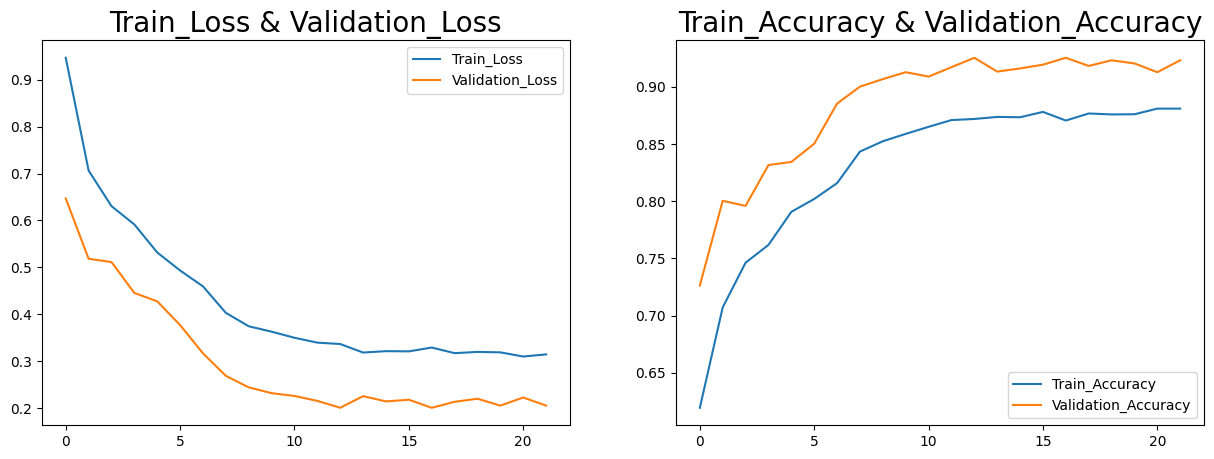

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(logs['train_loss'],label='Train_Loss')
plt.plot(logs['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(logs['train_acc'],label='Train_Accuracy')
plt.plot(logs['val_acc'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
